# Мастерская. Метод поиска ближайших соседей. Решение IVFPQ + CatBoost

<u>Цель проекта</u> -- разработать алгоритм, который для всех товаров (запросов) из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`.\
Оценку качества алгоритма произвести по метрике `accuracy@5`.

Алгоритм выбора товара должен обеспечивать достаточную скорость поиска.

<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

В данном ноутбуке код в некоторых ячеках представлен в формате "Необработанный NBConvert".\
Это сделано для того, чтобы исключить выполнение кода (как правило в наиболее "ресурсоёмких" ячейках), но вместе с тем проиллюстрировать ход мыслей и показать отдельные промежуточные результаты.

</div>

In [1]:
import re
import time

import pandas as pd
import numpy as np

from matplotlib import pyplot
import seaborn as sns


# библиотека для нормализации данных
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler
# from adjdatatools.preprocessing import AdjustedScaler


# библиотека поиска ближайших соседей от FB
import faiss


from sklearn.model_selection import (
#     RandomizedSearchCV, 
    GridSearchCV
)

from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier


pd.set_option('display.max_columns', None)

# переменные
RANDOM_STATE = 34

# кол-во данных для обучения, в % (долях) к размеру train'a
TRN_DATA_PCNT = 0.4

### Функции

Для выбора оптимальных параметров используется функция `opt_refit_strategy_accuracy`.

In [2]:
# сервисная функция для редактирования ключей в словаре 
def dict_keys_sub(source_dict, repl=''):
    
    """Функция для редактирования ключей в словаре
    Аргументы:
    'source_dict' - исходный словарь
    'repl'        - значение для замены паттерна, по умолчанию - '' (удаление паттерна)
    """
    
    # получает список ключей и список значений
    keys = list(source_dict.keys())
    values = list(source_dict.values())
    
    # проверяет необходимость обхода словаря по первому ключу (!)
    # ищет шаблон: "любые символы от начала строки до двух нижних подчёркиваний (__)"
    match = re.search('^(.+__)', keys[0])
    
    # шаблон найден
    if match:
        # получает паттерн
        pattern = match.group()
        
        # обходит список ключей
        for i in range(len(keys)):
            # редактирует значения списка ключей в цикле - заменяет паттерн на repl
            keys[i] = re.sub(pattern, repl, keys[i])
 
        # возвращает новый словарь, созданный из изменённого списка ключей и списка значений
        return dict(zip(keys, values))
    
    # возвращает исходный словарь
    else:
        return source_dict


In [3]:
# сервисная функция для вывода на печать строк ДФ
def print_dataframe(filtered_cv_results):
    # формирует срез данных ДФ для вывода на печать
    for mean_train, mean_test, max_delta, worst_score, params in zip(
#     for mean_train, mean_test, params in zip(
        
    filtered_cv_results["mean_train_score"],
    filtered_cv_results["mean_test_score"],    
    filtered_cv_results["max_delta"],
    filtered_cv_results["the_worst_score"],
    filtered_cv_results["params"]
    ):
        # выводит на печать выбранные данные:
        print(
            f"train_score: {mean_train:0.3f},"
            f" test_score: {mean_test:0.3f},"
            f" max_delta: {max_delta:0.5f},"
            f" worst_score: {worst_score:0.3f},"
            f" for params: {dict_keys_sub(params)}"
            )
    print()


In [4]:
# функция выбора оптимальных параметров для accuracy
def opt_refit_strategy_accuracy(cv_results, if_print=True):
    
    """Функция производит оценку и подбор гиперпараметров по критерию соотношения "Лучшая метрика" / "Переобученность".
    
    --------- Примечание:
    Функцию можно улучшить и сделать универсальной для всех метрик, если научиться передавать в функцию конкретную метрику 
    (метрики), используемые моделью метрики (например, получать через колбеки):
        все метрики условно делятся на два вида: 
            - значения которых мы стремимся максимизировать 
            - значения которых мы стремимся минимизировать.
        Исходя из этого настраивается поведение функции.
    ------------------------
        
    Для оценки переобученности модели вводится понятие **'delta' (дельта)** 
        – разница между результатами модели на тестовой (`test`) и обучающей (`train`) выборках 
        (в большинстве случаев результат `test` будет хуже `train`’а).

    Для текущих гиперпараметров модели определим "Наихудший результат":
    сумма/разность наихудшего результата на тестовой (`test`) выборке из всех фолдов:
        - для метрик, значения которых мы стремимся минимизировать (например, RMSE) 
            наихудшим результатом будет максимальное значение результата из всех фолдов
        - для метрик, значения которых мы стремимся максимизировать, (например, accuracy) 
            наихудшим результатом будет минимальное значение результата из всех фолдов
    и максимального значения дельты из всех фолдов.
    
    Таким образом мы получим некий "Максимально возможный наихудший результат" ("Максимальный наихудший результат")
    из всех возможных при имеющихся данных и текущих гиперпараметрах модели.
    Ситуацией 'max delta' ==> 'best score' пренебрегаем, т.к. наша задача – оценка по наихудшей вероятности.
    По той же причине не используем усреднённые значения 'mean_test_score' / 'mean_train_score'.
    
    Вычислим 'Максимально наихудшие результаты' для всех полученных вариантов гиперпараметров 
    и отсортируем их в порядке возрастания/убывания (в зависимости от вида метрики-оценщика).

    Первая строка даст оптимальный из всех вариантов гиперпараметров.

    Логика:
    отбрасываются варианты изменения гиперпараметров, 
    при которых из-за переобучения модели может быть получен худший результат, чем при других вариантах гиперпараметров.
    """
    
    
    """Функция используется дважды:
    первый раз - по прямому назначению как функция выбора оптимальных параметров передаётся
    в 'refit' при переборе гиперпараметров и кросс-валидации. Поскольку в этом случае 
    функция передаётся в качестве аргумента в методы 'GridSearchCV' или 'RandomizedSearchCV'
    и выполняется "из-под" них, результаты выполнения функции невозможно сохранить 
    и передать куда-либо, поскольку 'Python' не позволяет менять переменные вне области видимости функции.
        Поэтому приходится запускать её
        
    второй раз - для обработки и получения результатов кросс-валидации 'cv_results'.
    В первом случае нам нужен вывод на печать результатов, во втором - нет.
    В первом случае при досрочном выходе возвращает 'True', а при нормальном - номер индекса строки,
    во втором в любом случае возвращает номер индекса строки и созданный ДФ.
    """
    
    """В параметрах метода автоматического поиска параметров GridSearchCV и RandomizedSearchCV
    должно быть задано "return_train_score = True" – «возвращать результаты трейна».
    
    На вход получает таблицу результатов кросс-валидации "cv_results_"
    На выходе – индекс строки с наилучшей оценкой, как он отображается в этой таблицы результатов.
    """
    
    # пороговое значение результата
    Threshold = 0.5
    
    # преобразует результаты в ДФ
    res = pd.DataFrame(cv_results)
    
    # получает список гиперпараметров модели
    key_names = list(cv_results.get('params')[0].keys())    
    if if_print:
        print(f"Изменяемые гиперпараметры модели: {key_names}")
    
    # получает кол-во столбцов, содержащих в названии 'split' и 'test':
    # применяет фильтр к меткам индекса столбцов
    q_folds = res.filter(regex=('split.+test')).shape[1]
    if if_print:
        print(f"Количество фолдов: {q_folds}")
    
#     # умножает столбцы средних значений результатов на -1, 
#     # т.к. результаты выражены отрицательными числами
#     res["mean_train_score"] = res["mean_train_score"] *-1
#     res["mean_test_score"] = res["mean_test_score"] *-1
    
    # в цикле по кол-ву фолдов создаёт столбцы дельты для каждого фолда:
    for i in range(q_folds):
        # формирует имена столбцов: 'deltaN' и 'splitN_test_score' и 'splitN_train_score'
        delta_column_name = 'delta' + str(i)
        test_column_name = 'split' + str(i) + '_test_score'
        train_column_name = 'split' + str(i) + '_train_score'
        # создаёт столбец дельты 'deltaN'
#         res[delta_column_name] = (res[test_column_name] *-1) - (res[train_column_name] *-1)
        res[delta_column_name] = res[train_column_name] - res[test_column_name]
        
    
    # создаёт столбец максимальных значений дельты    
    res['max_delta'] = res.filter(regex='^(delta?)').max(axis=1)
    
    # создаёт столбец максимальных (!) значений результатов на тесте
    # т.к. все значения в столбцах отрицательные, находит минимальное (!) значение и умножает на -1
#     res['max_test_score'] = res.filter(regex=('split.+test')).min(axis=1) *-1
    res['min_test_score'] = res.filter(regex=('split.+test')).min(axis=1)
    
    
    # создаёт столбец наихудших возможных результатов
    res['the_worst_score'] = res['min_test_score'] - res['max_delta']    
    
    # вызов из-под 'pipeline'
    if if_print:
        # распечатывает данные всех строк НЕ сортированного ДФ 
        # для визуального отображения изменения гиперпараметров
        print("Все результаты по порядку изменения гиперпараметров:")
        print_dataframe(res)
        print()
    
    # сохраняет только необходимые данные ДФ
    stat = res[["mean_train_score","mean_test_score","max_delta","the_worst_score",
                "mean_fit_time", "mean_score_time", "params"]]
    
    # удаляет лишнюю переменную
    del res
    
    # отфильтровывает все результаты ниже порогового значения
#     low_stat = stat[stat["the_worst_score"] < Threshold ]
    low_stat = stat[stat["the_worst_score"] > Threshold ]
    
    
    # нет результатов ниже порогового значения
    if low_stat.shape[0] == 0:
        
        # вызов из-под 'pipeline'
        if if_print:
#             print(f"Для выбранной модели НЕ БЫЛИ ДОСТИГНУТЫ значения 'RMSE' НИЖЕ порогового значения {RMSE_threshold}\n"
            print(f"Для выбранной модели НЕ БЫЛИ ДОСТИГНУТЫ значения ВЫШЕ порогового значения {Threshold}\n"                  
                  f"НИ НА ОДНОМ из заданных наборов гиперпараметров.")
            print()
            return True
        
        # вызов НЕ из-под 'pipeline'
        else:
            # выбирает модель с наилучшим результатом:
            # сортирует по возрастанию, чтобы модель с наилучшим результатом оказалась в начале списка
#             opt_index = stat.sort_values(by=['the_worst_score','mean_score_time']).index[0]
            opt_index = stat.sort_values(by=['the_worst_score','mean_score_time'], ascending=True).index[0]
            
            
            # возвращает индекс и ДФ
            return opt_index, stat

    # вызов из-под 'pipeline'
    if if_print:
#         print(f"Следующие наборы гиперпараметров ДОСТИГЛИ порогового значения 'RMSE' НИЖЕ {RMSE_threshold}:")
        print(f"Следующие наборы гиперпараметров ДОСТИГЛИ порогового значения ВЫШЕ {Threshold}:")
        
#         print_dataframe(low_stat.sort_values(by=['the_worst_score'], ascending=False))
        print_dataframe(low_stat.sort_values(by=['the_worst_score'], ascending=True))
        
        print()
    
    # выбирает модель с наилучшим результатом:
    # сортирует по возрастанию, чтобы модель с наилучшим результатом оказалась в начале списка
#     opt_index = low_stat.sort_values(by='the_worst_score').index[0]
    opt_index = low_stat.sort_values(by='the_worst_score', ascending=False).index[0]
    

    # вызов из-под 'pipeline'
    if if_print:
        print(
#             "\nВыбранные гиперпараметры являются оптимальными по соотношению качества прогноза по метрике RMSE\n"
            "\nВыбранные гиперпараметры являются оптимальными по соотношению качества прогноза по метрике accuracy\n"
            "и переобученности модели 'max_delta':")    
        print_dataframe(low_stat.loc[[opt_index]])
        
        # возвращает только индекс
        return opt_index   
            
    # вызов НЕ из-под 'pipeline'
    else:
        # возвращает индекс и ДФ
        return opt_index, stat


## Загрузка данных 

### Train

Обучающий датасет (файл "train.csv"):
- id запросов: 0-query, 1-query, 2-query и т.д.
- сам вектор
- наиболее правильный ответ по мнению экспертов: 675816-base, 366656-base, 366656-base и т.д.

In [5]:
xq = pd.read_csv("train.csv", index_col=0)
xq.shape

(100000, 73)

In [6]:
xq.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.82184,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.25095,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.51382,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.78345,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.63687,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.63211,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.12843,-50.83762,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.32178,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.86585,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.67767,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.93147,-1074.464888,-22.547178,1447819-base


Правильные ответы выделяем в отдельную сущность и исключаем этот вектор ("дропаем").
Получаем массив без последней колонки и отдельный массив правильных значений.

In [7]:
targets = xq["Target"]
xq.drop("Target", axis=1, inplace=True)

In [8]:
targets.head(3)

Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
Name: Target, dtype: object

In [9]:
xq.shape

(100000, 72)

В отдельную переменную записываем индексы массива:

In [10]:
xq_idx = xq.index

### Base

Подгружаем "базовый" датасет (очень большой файл). Задаём индекс - это нулевая колонка:

In [11]:
%%time
# столбец-индекс - нулевой столбец
xb = pd.read_csv("base.csv", index_col=0)

CPU times: total: 19.4 s
Wall time: 20 s


In [12]:
xb.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.44970,-124.06151,-32.458237,-57.42056,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.90536,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.77318,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.81218,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.23419,-141.30435,-126.768900,-68.85353,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.57684,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.91463,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.83284,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.38147,-140.82245,-22.486748,-51.66699,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.34451,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.76731,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.97963,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.07349,116.594154,-1074.464888,-32.527206


"0-base", "1-base" и т.д. - названия товаров\
72 параметра - это вектор признаков описания товара и всего почти 3 млн. товаров

In [13]:
xb.shape

(2918139, 72)

In [14]:
xb.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4744762-base,-97.02673,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,118.76070,-110.06689,-89.143280,-74.895386,14.897295,190.56699,-12.973312,-12.152755,-42.322410,-108.64503,-79.032310,-97.78705,400.784910,2.078598,59.333366,0.367243,62.721123,-61.804890,10.855421,-115.550660,153.25854,-10.300577,-196.60452,70.91812,-1043.159721,70.956480,101.547070,-13.259350,-139.23843,-113.571495,-19.486378,-6.151489,2.193967,-96.10269,73.53148,-51.405546,64.929040,-128.39260,-233.73950,70.930664,15.026978,120.075470,4.885176,76.242190,-119.228676,88.955574,66.884865,-139.85466,40.561203,-164.06183,-509.143096,-147.723750,-118.98360,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300
4744763-base,-86.83843,8.911945,-34.837738,-106.46268,42.236572,-96.194230,-532.907338,9.845185,126.037560,59.22310,-154.80347,17.351677,-57.850357,38.388275,196.08038,-30.622873,32.849995,53.229084,-114.61604,-78.776850,-94.58158,1507.231274,55.395218,120.432920,15.564391,585.357843,-32.565628,12.867737,-50.254520,151.21098,-5.801586,-95.91889,102.57959,-218.993723,14.499689,68.840160,-2.475177,-145.62883,-132.143110,-19.993330,-13.653464,-12.230000,-107.60946,67.61426,-32.260562,28.595524,-84.51782,-215.26077,43.375030,-93.147415,76.284320,-33.716904,57.013706,-175.003540,88.136730,82.277510,-136.51123,27.754803,-98.03558,-268.438506,-50.803364,-135.37442,-86.867020,-6.959065,-174.07591,-151.007973,68.622246,0.707927,94.451866,124.843000,-1074.464888,-55.789314
4744766-base,-101.96527,12.859500,-51.393135,-168.21826,101.065110,-71.914600,34.734278,-5.394417,135.523760,125.36194,-150.43762,-147.076420,-98.145220,13.159228,154.87372,-22.442291,-29.002089,8.112659,-125.67428,-78.617325,-86.06845,889.961374,34.192290,59.176920,-48.720250,813.770071,-84.096750,16.414843,-72.618835,160.03128,26.076294,-127.69979,103.55976,-693.493298,-12.338760,42.321697,-3.191654,-127.16026,-97.001080,-20.773820,-7.465384,0.273660,-189.48654,73.88411,-33.410550,17.845676,-183.84543,-109.48555,30.738031,-83.298400,69.309525,86.705700,68.972310,-55.488354,79.908035,80.541630,-142.46292,-22.157806,-100.34217,-409.243837,-119.637970,-122.08988,-67.404680,72.963425,-147.85870,-5.081259,69.688720,-20.186157,84.479110,92.833786,-1073.826170,14.774761


В отдельную переменную записываем индексы массива:

In [15]:
xb_idx = xb.index

### "Словарь"

Видим, что единственным идентификатором вектора является индекс `Id` "базы". Однако нумерация этих индексов не сквозная и соотв-но не совпадает с нумерацией собственно строк "базы". Это не очень удобно, так как резульатом поиска будет являться именно список номеров строк.\
Для решения проблемы создадим "словарь": передадим индексы "базы" списком (`xb.index.to_list()`) и пронумеруем подряд от 0 до конца (в данном случае -- по кол-ву строк).\
Теперь `xb_dict` - это словарь, в котором сказано, что нулевой вектор - 0-base, первый вектор - это 1-base и т.д., то есть вида {0: '0-base', 1: '1-base', 2: '2-base' ...} и т.д.

In [16]:
xb_dict = {k: v for k, v in enumerate(xb.index.to_list())}

In [17]:
xb_dict[11], xb_dict[xb.shape[0]-1]

('11-base', '4744766-base')

In [18]:
len(xb_dict)

2918139

### Функция подсчёта accuracy

Считаем `accuracy`:
- берём значения правильных предсказаний из `targets` и переводим их в список (`targets.values.tolist()`)
- берём рекомендации, которые нам выдал `idx` (`Results`) и тоже переводим в список
- используя итератор `zip` создаём объект `zip` в котором пары представляют собой Id строки из 'base' (`NNNN-base`) и номера строк из 'base', рекомендованных поиском в качестве соседей
- проходим по каждой паре (`for target, el in zip...`) и смотрим:
    - если в рекомендованных строках есть номер строки, которая из словаря `xb_dict`  возвращает значение Id (`..target in [base_dict[r]..`), то считаем, что это "1",
    - если нет, то это "0",\
    (функция `int` переводит возвращаемые логические условия "True/False" в "1/0")     
- суммируем нули и единицы (`acc +=`)
- и делим результат на общее кол-во записей (длину датасета) (`acc / len(Results)`)
- умножаем на 100, чтобы сместить знак после запятой и получаем значение `accuracy`.
    

In [19]:
# функция подсчёта 'accuracy'
def accuracy(Results, df_targets=targets, base_dict=xb_dict):
    
    acc = 0
    for target, el in zip(df_targets.values.tolist(), Results.tolist()):

        # т.е фактически здесь условие 'if ...' - "если таргет есть в [base_dict[r] ... "
        acc += int(target in [base_dict[r] for r in el])

    return (100 * acc / len(Results))


**________________________________________________________________________________________________________________________**

## Распределение и отдельные статистики

In [20]:
print(faiss.MatrixStats(xb).comments)

analyzing 2918139 vectors of size 72
no NaN or Infs in data
all vectors are distinct
range of L2 norms=[798.898, 2713.41] (0 null vectors)
matrix contains no 0s
no constant dimensions
no dimension has a too large mean
stddevs per dimension are in [0.75744 399.961]



Используя статистический метод библиотеки `faiss` получаем некоторые данные по векторам "базового" датасета:
- нет пропусков и NaN'ов
- все векторы различны (одинаковых векторов нет)
- нет "нулей"
- нет постоянных размеров векторов
- получили диапазоны L2 нормы и среднего отклонения

### Размеры (расстояния)

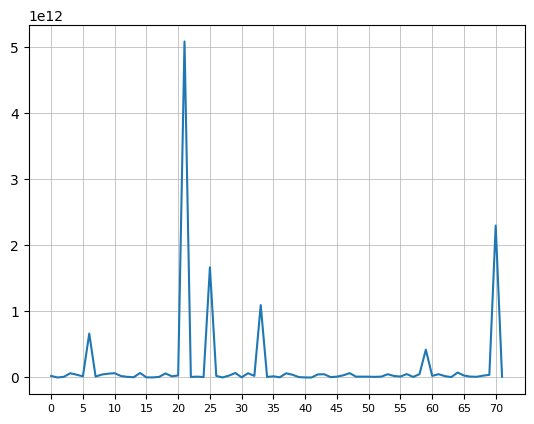

In [21]:
pyplot.plot((xb ** 2).sum(0))
pyplot.xticks(range(0, xb.shape[1], 5), fontsize=8)
pyplot.grid(linewidth=0.5)
pyplot.show()

Видим, что как минимум у 6 векторов расстояния существенно больше остальных, причём у одного ("21") расстояние отличается от остальных очень сильно. Это информацию нужно учитывать при подготовке данных.

## Исходные условия 

Используя метод `knn` (ближайшие соседи) библиотеки `faiss` найдём 100 ближайших соседей для наших запросов и нашего пространства.

<u>Комментарий</u>\
описание функции `faiss.knn` вообще не удалось найти: в официальной документации его нет. Однако, по косвенным упоминаниям можно предположить, что функция выполняет поиск ближайших соседей "грубым методом" -- ищет минимальные расстояния путём перемножения векторов, что занимает довольно много времени. Тем не менее, разработчики `faiss` используют данную функцию как некий эталон  точности: результаты всех других методов `faiss` в документации сравниваются с результатами поиска именно этой функцией -- такой результат принимается за некую условную единицу (1).

Видим, что для метрики `accuracy@100` результат `faiss.knn` составил всего 0.222 (!). Пространства не совпадают. 

Здесь возможны два предполжения:
- что-то не так с нашим пространством векторов
- что-то не так с ответами экспертов, т.к. `accuracy` в данном случае определяется НЕ исходя из математического результата, а исходя из неких заранее заданных ответов.

Вспомним о нескольких векторах, расстояния которых существенно отличались от остальных при возведении в квадрат (метрика L2), и предположим, что причина всё-таки в пространстве векторов. Попробуем нормализовать и масштабировать это пространство, чтобы снизить влияние отдельных признаков.

## Нормализация (масштабирование)

Были использованы следующие стандартизаторы:
- `StandardScaler` from sklearn.preprocessing
- `RobustScaler` from sklearn.preprocessing
- `MinMaxScaler` from sklearn.preprocessing 
- `AdjustedScaler` from adjdatatools.preprocessing


In [22]:
xq = pd.DataFrame(StandardScaler().fit_transform(xq),
                             columns = xq.columns)

xb = pd.DataFrame(StandardScaler().fit_transform(xb),
                             columns = xb.columns)

Оценим результат стандартизации с помощью функции `faiss.knn`:

Наилучший результат показал как ни странно банальный `StandardScaler`:\
с ним метрика  `accuracy@100` по `faiss.knn` улучшилась сразу до 77.685.\
(результаты остальных не сохранились, так что здесь привести их здесь не могу)

<u>Комментарий</u>\
скачок метрики с нуля до 77 при стандартизации впечатляет. Подозреваю, что такого быть просто не должно и где-то сидит ошибка.

Наилучшего результата можно добиться, изменив метрику в функции `faiss.knn` с `faiss.METRIC_INNER_PRODUCT` на `faiss.METRIC_L2` (всё-таки у нас для поиски ближайших соседей используется Евклидово расстояние) как в коде ниже.

### Удаление признаков

Попробуем удалить признаки, имеющие наибольшее расстояние (размер) (оцениваем по графику выше) и оценить влияние такого удаления на результат.

Путём проб и ошбок выявили три признака, удаление которых улучшило итоговый результат:

In [23]:
# удаляемые признаки
droped_columns = ['21','25','33']

In [24]:
xq.drop(droped_columns, axis=1, inplace=True)
xb.drop(droped_columns, axis=1, inplace=True)

**Процесс выбора завершён**\
Видим, что результат улучшился на пару процентов.

In [25]:
xb.shape

(2918139, 69)

In [26]:
# "расстояние" - размерность векторов в базе
dim = xb.shape[1]
dim

69

In [27]:
# вернём массивам индексы - он "обнулились" (0-1-2...) при преобразовании значений
xq.index = xq_idx
xb.index = xb_idx

Определим "максимально достижимое" значение `accuracy@5`: выполним поиск 5 ближайших соседей методом `faiss.knn`.

Результат `accuracy@5` по `faiss.knn(k=5)` уменьшился более чем на 10% и составил **69.438**.\
Запомним эту цифру.

## Create index

Для выбора лучшего метода поиска были проанализированы следующие методы `faiss`:
- метод  `Scalar quantizer encoding (SQ)` -- очень медленно!
- метод `OPQ{D},PQ{D}x4fs,RFlat` (поворот и кодирование векторов) -- очень медленно!
- Non-exhaustive search `HNSW` (неисключительный поиск с алгоритмом индксов, основанных на графах)
- Non-exhaustive search `IVF` (неисключительный поиск с алгоритмом "обратного файлового индекса" (`IVF`))
- `Differential indexing` (дифференциальная индексация)

С последним методом (Differential indexing) возникла проблема: была замечена "подмена" индексов -- в `I_diff` появляются индексы, **отсутствующие** в словаре `xb_dict`. С причиной такого поведения разобраться не смог, от использования метода пришлось отказаться, хотя в документации `faiss` он позиционируется как самый быстрый и самый точный.

Из остальных методов наилучшие результаты показал неисключительный поиск с алгоритмом "обратного файлового индекса" (`IVF`) в модификации `IVFPQ` (повышенная скорость с сохранением точности).

Значения общего количества калстеров (ячеек) `n_cells` и количества посещаемх кластеров `idx_l2.nprobe` подобраны эксперементальным путём и возможно не являются оптимальными.

### Общее количество ячеек (кластеров)

In [28]:
# кол-во ячеек (кластеров)
n_cells = 33

<u>Комментарии студента</u>

Количество кластеров является важным параметром, обеспечивающим качество построения пространства векторов и, в конечном счёте, результат работы модели: изменение количества кластеров улучшало или ухудшало результат при прочих неизменных параметрах. 

Данное значение выбрано "методом тыка".\
Возможно, существует алгоритм расчёта оптимального количества кластеров для заданного набора векторов, однако я не сумел в этом разбораться.


In [29]:
# "сейчас буду бросать в тебя вектора размером 72 (dims) и их близость буду оценивать по Евклидовой норме"
# quantizer - "квантователь"
quantizer = faiss.IndexFlatL2(dim)

m = dim  # number of centroid IDs in final compressed vectors -- (!) должно быть равно размеру вектора!
bits = 8 # number of bits in each centroid

idx_l2 = faiss.IndexIVFPQ(quantizer, dim, n_cells, m, bits) 

`IndexFlatL2` означает, что мерой близости будет **Евклидово расстояние**. То есть какие-то признаки будут вносить больший вклад, какие-то -- меньший. Вспоминаем линейную регрессию и зачем мы там вообще нормируем признаки. Это как раз всё оттуда.\
Это к вопросу о важности стандартизации и нормализации.

Обучает (строит пространство векторов?) и добавляет все вектора в индекс.

In [30]:
%%time
idx_l2.train(np.ascontiguousarray(xb.values[:50000, :]).astype('float32'))   # --> @5 68.664
# idx_l2.train(np.ascontiguousarray(xb.values).astype('float32'))   # --> @5 68.579

idx_l2.add(np.ascontiguousarray(xb.values).astype('float32'))

CPU times: total: 16min 35s
Wall time: 42.6 s


<u>Комментарии студента</u>:

здесь удивило, что переданное в train количество строк (50 тыс.) обеспечивает лучшее формирование пространства векторов, чем полностью переданный ДФ `xb`: на поиске по всем запросам пространство, сформированное из первых 50 тыс. векторов `base` обеспечивает лучший результат по сравнению с пространоством, сформированным из всех векторов: 68.664 vs 68.579. Разница довольно несущественная -- менее 0.1 пп при 5 ближайших соседях, но при 100 ближайших соседях она возрастёт более чем вдвое: vs  77.219 vs 76.889. Значение 50 тыс. осталось с "демонстрационного" base-line решения.

In [31]:
# кол-во значений в индексе
idx_l2.ntotal

2918139

На этом предварительная история закончена.

**________________________________________________________________________________________________________________________**

## Search

Задаёт количество посещаемых кластеров: чем больше это количество, тем точнее (в теории) дожен быть результат, но больше время поиска.

### Количество посещаемых кластеров

In [32]:
# кол-во посещаемых кластеров
idx_l2.nprobe = 5

In [33]:
idx_l2.nprobe

5

Ниже показано, что увеличение кол-ва посещаемых кластеров с 3 до 5 при метрике @5 улучшает результат примерно на 1 пп: с 67.698 до 68.664.
Однако при дальнейшем увеличении кол-ва калстеров до 8 прирост результата замедляется с каждым шагом, но при этом реальное время поиска возрастает почти в 2 раза: с Wall time: 2min 56s до Wall time: 4min 42s.

<u>Вывод</u>:\
в увеличении количества посещаемых кластеров выше 5 нет смысла, так как с этого момента результат перестал существенно улучшаться.

### Собственно поиск

Выполняет поиск: передаёт вектора запроса в индекс поиска.

Индекс вернёт массив индексов строк ДФ `base` (xb), рекомендуемых в качестве ближайших соседей, и массив расстояний, соответствующих этим строкам. Оба массива  отсортированы по возрастанию значений расстояний.

In [34]:
%%time
dist, idx =\
idx_l2.search(np.ascontiguousarray(xq.values).astype('float32'), 5)

CPU times: total: 1h 8min 14s
Wall time: 2min 53s


In [35]:
accuracy(idx)

68.664

Метрика `accuracy@5` составила 68.664 vs 69.438 -- "идеального" значения метрики (см. выше).\
При этом время поиска составило 2min 56s vs 6min.\
То есть пожертвовав менее 1 пп результата,  мы ускорили поиск вдвое.

Для 100 ближайших соседей метрика accuracy@100 составила 78.85 vs 80.727 ("идеального" значения метрики). Здесь разница в точности составила уже почти 2 пп. Время поиска практически не меняется для обоих ситуаций.

<u>Выводы</u>:

1. Поиск с использованием методов `faiss` фактически представляет собой компромисс между точностью и скоростью.
Тем не менее, отдельные методы позволяют существенно увеличить скорость поиска при минимальных потерях в точности.
<br><br>

2. Представляется важным и заслуживающим отдельного внимания правильный подбор параметров "общее количество кластеров" и "количество посещаемых кластеров". Возможно, существуют алгоритмы поиска соответствующих оптимальных значений.\
При этом увеличение числа посещаемых векторов "в лоб" не приводит к линейному повышению результата:\
при разбиении пространства векторов на кластеры правильные ответы (значения) попадают в другие кластера и не находятся среди предлагаемых поиском вариантов ближайших соседей.
<br><br>

3. По этой причине **наиболее важным представляется этап подготовки данных** для формирования пространства векторов: мы наблюдали эффект увеличения результатов от 0 до 77 в результате проведения простой нормализации данных. Даже если допустить, что этот начальный "0" был ошибкой, последующее улучшение результатов при удалении отдельных признаков показывает, что изменяя свойства пространства векторов можно добиться улучшения итоговго результата.\
К сожалению, лучшей конфигурации пространства я добиться не смог.
<br><br>

4. Метрика `@k` результата поиска методом `faiss` `k` ближайших соседей не может быть улучшена путём добавления к поиску отдельной модели, поскольку в результаты поиска НЕ попали "правильные ответы" (номера строк), ухудшившие итоговую метрику и эти номера не могут быть найдены другой моделью.

Иными словами, на данном этапе (при использовании выбранных способов обработки данных и формирования пространства векторов) "потолк" для метрики `accuracy@5` составляет **69.438** (наилучиший результат для поиска 5 ближайших соседей методом `faiss.knn`). Получить метрику выше этого значения, используя только поиск "в лоб" -- для 5 ближайших соседей -- не получится.


Единственный выход здесь -- увеличивать количество ближайших соседей `k` в поиске (увеличивать число возвращаемых поиском строк), чтобы с помощью дополнительной модели выбрать из этих строк наиболее подходящие результаты, которые попадут в метрику `@5`.\
Попробуем реализовать этот подход на практике.

## Построение модели

Попробуем построить модель, которая будет предсказывать вероятность соответствия строки базы (`xb`) строке запроса (`xq`). Тем самым мы можем несколько улучшить итоговое значение метрики `@5`: если передать в модель 100 строк, рекомендованных поиском в качестве ближайших соседей для строки запроса (`xq`), модель предскажет вероятность для каждой строки. Далее останется только отсортировать строки по значению этой вероятности и взять первые или последние 5 строк.

Если в результате будет получено превышение значения **69.438** по метрике `accuracy@5`, то модель работает.

### Готовим данные

<u>Тип решаемой задачи</u> - бинарная классификация: значение класса целевого признака либо "1" (соответствие), либо "0" (не соответствие).

Используем модель классификации градиентного буситнга, например, `CatBoost`.

Для обучения модели нам нужно будет сформировать обучающий датасет, в котором каждой строке запроса (`xq`) будет соответствовать `k` строк рекомендаций из базы `xb`, выданных поиском `faiss`.

Таким образом общий размер тренировочного датасета составит `N * k` строк, где `N` - выбранное для обучения кол-во строк из ДФ запросов `xq`: при выборке из 10 тыс. строк и поиске по 100 ближайшим соседям размер обучающего датасета составит 1 млн. строк.

Опять же возникает мощнейший дисбаланс классов (в примере это 1:100), который невозможно (?) компенсировать, так как в любом тестовом и рабочем датасетах дисбаланс будет точно таким же.

Ниже приводится изменение значения метрики `accuracy` для различных `k` ближайших соседей:

Видно, что значения метрики изменяются нелинейно: начиная примерно с 50 дальнейший рост числа ближайших соседей даёт уже не такой большой прирост к изменению значений метрики. Следовательно, брать значения `k` выше 50 не имеет особого смысла.

Построим тренировочную выборку следующим образом:
- из ДФ запросов `xq` возьмём 4 тыс. строк
- и выполним для них поиск по 10 ближайшим соседям\
    Исходим из того, что для качественного обучения модели требуется порядка 2-3 тыс. значений, однако при точности поиска в 71% (@10 для 10 ближайших соседей) почти треть результатов не будут содержать подходящих индексов строк и мы не будем включать их в тренировочную выборку. В итоге останется чуть менее 3 тыс. запросов.
- получим ~ 3000 * 10 = ~ 30 000 индексов строк базового ДФ `xb`
- объединими полученные вектора "запрос + базовый вектор-рекомендация"
- подсчитаем и выделим целевой признак (класс "1/0") 
- передадим полученный ДФ модели. 

<u>Комментарии студента</u>

Сначала выполнил поиск по 25 ближайшим соседям вместо 10.\
Получил тренировочный ДФ с жутким дисбалансом классов. В резульате не смог добиться более-менее приемлемых метрик: 'recall' не поднимался выше 0.56, а точность и F1-мера вообще упали ниже 0.40.\
В итоге решил уменьшить дисбаланс и формирование обучающей выборки через поиск всего по 10 ближайшим соседям.

In [36]:
%%time
# передаёт в поиск часть строк ДФ запросов 'xq', будут найдены 10 вариантов ближайших соседей
D_trn, I_trn =\
idx_l2.search(np.ascontiguousarray(xq.sample(frac=TRN_DATA_PCNT, random_state=RANDOM_STATE).values).astype('float32'), 10)

CPU times: total: 27min 23s
Wall time: 1min 9s


In [37]:
%%time
acc = 0
matched_elements = []     # совпадающие элементы
matched_idx = []          # совпадающие индексы (строки запросов)

# добавляем номер итерации 'i', чтобы можно было использовать индексы строк, в остальном - как при подсчёте 'accuracy'
for i, (target, el) in enumerate(zip(
    targets.sample(frac=TRN_DATA_PCNT, random_state=RANDOM_STATE).values.tolist(), I_trn.tolist()
)):
    if target in [xb_dict[r] for r in el]:
        acc += 1
        matched_elements.append(el)        
        matched_idx.append(i)    

print(100 * acc / len(I_trn))

72.005
CPU times: total: 281 ms
Wall time: 184 ms


In [38]:
# кол-во дубликатов, включая старую строку. Равно кол-ву вариантов ближайших соседей
dup_nb = I_trn[0].shape[0]
dup_nb

10

In [39]:
# проверяем размеры
len(matched_idx), len(matched_elements)

(28802, 28802)

In [40]:
# переводим в массив 'numpy'
matched_elements = np.asarray(matched_elements, dtype=int)
matched_elements.shape

(28802, 10)

Делим задачу на две части:
1. Создадим ДФ `xq_tr`: проходим `xq` и дублируем каждую строку `K` раз
2. Создадим ДФ `xb_tr`:
    - нужно взять `K` строк из `xb`, так, чтобы они совпадали по порядковому номеру в списке с `K` индексами
    - повторить `N` раз: каждый раз для новой `xq` строки
3. Объединяем два созданных ДФ: размерность по строкам должна быть одинакова для обоих ДФ `_tr`
4. Удаляем лишнее

### Создаём ДФ `xq_tr` 

In [41]:
# создаёт ДФ запросов 'xq_trn' только из тех запросов, к которым были найдены правильные ответы,
# и "разбавляет" их дубликатами строк, при этом кол-во дубликатов, включая исходную строку, 
# равно кол-ву вариантов ближайших соседей 'dup_nb'
xq_trn = pd.DataFrame(np.repeat(xq.sample(frac=TRN_DATA_PCNT, random_state=RANDOM_STATE).iloc[matched_idx].values,
                                dup_nb, axis=0), columns=xq.columns)
xq_trn.shape

(288020, 69)

In [42]:
xq_trn.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038
1,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038
2,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038


In [43]:
targets.sample(frac=TRN_DATA_PCNT, random_state=RANDOM_STATE).iloc[matched_idx].values

array(['729473-base', '745897-base', '1883484-base', ..., '137116-base',
       '668460-base', '595769-base'], dtype=object)

In [44]:
# создаёт столбец 'target' в тренировочном ДФ 'xq_trn'
xq_trn['target'] =\
    pd.DataFrame(np.repeat(targets.sample(frac=TRN_DATA_PCNT, random_state=RANDOM_STATE).iloc[matched_idx].values,
                           dup_nb, axis=0))

In [45]:
xq_trn.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
0,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base
1,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base
2,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base


In [46]:
xq_trn.shape

(288020, 70)

### Создаём ДФ `xb_trn` 

В ДФ `xb_trn` войдут ВСЕ строки ДФ `xb`, рекомедованные в качестве ближайших соседей, среди которых ЕСТЬ правильный ответ:

In [47]:
xb_trn = xb.iloc[matched_elements.flatten()]
xb_trn.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
729473-base,-2.107428,0.097889,0.770035,0.290410,-1.110240,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959
512493-base,-2.034321,-0.144503,0.530324,0.578903,-0.855282,0.041751,-1.352459,-0.433286,-0.394335,0.746682,0.479438,-0.148900,0.695088,0.673253,-1.183562,0.223840,1.003353,0.353450,-1.003351,0.139829,0.971592,-0.689235,0.269543,0.543900,-1.054032,0.653762,1.181289,-1.186767,-0.403095,1.007785,0.518308,-1.805120,-1.618098,0.160417,0.176661,-1.457583,-0.440080,1.769824,-1.148421,-0.944770,1.466189,-0.502987,0.333097,-1.040593,-0.667001,-0.671862,-0.408511,1.661715,1.862993,0.171538,1.720408,-0.415441,-0.151795,0.691274,-0.358386,-0.770756,-1.500380,0.347785,-0.046917,0.293136,-0.266014,-1.168289,-1.694565,1.573848,-1.014951,1.363300,-1.876853,1.418002,-1.653441
551677-base,-2.726061,0.289246,1.238859,-0.217834,0.331897,-0.667385,-1.352459,-0.157371,-0.958831,1.088802,0.367320,-0.622669,-0.238169,0.864886,0.184182,0.108946,0.002825,0.679038,-0.520053,0.374692,-0.072887,0.293586,0.842205,-0.044667,-3.383147,-0.902968,2.358174,-0.047323,-1.018589,0.716618,-0.460907,-1.732546,-1.230248,0.875237,-0.405102,-0.615187,0.877661,-0.266340,0.140514,-1.542649,0.933162,0.179576,-1.158851,-2.202475,-0.909582,-0.221708,-0.512552,0.734877,0.781270,2.340739,1.036604,-0.755182,1.291446,0.346775,0.534238,-0.108004,-0.557211,-0.073782,-0.421483,0.685469,1.027754,-0.635885,1.110765,1.300070,0.337642,-0.299679,-1.819707,0.272932,-1.494222


In [48]:
# получает список столбцов
xb_trn.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26',
       '27', '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63',
       '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [49]:
# переводит индексы в отдельный столбец, одновременно перехешируя индексы строк
xb_trn.reset_index(inplace=True)
xb_trn.head(3)

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,729473-base,-2.107428,0.097889,0.770035,0.290410,-1.110240,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959
1,512493-base,-2.034321,-0.144503,0.530324,0.578903,-0.855282,0.041751,-1.352459,-0.433286,-0.394335,0.746682,0.479438,-0.148900,0.695088,0.673253,-1.183562,0.223840,1.003353,0.353450,-1.003351,0.139829,0.971592,-0.689235,0.269543,0.543900,-1.054032,0.653762,1.181289,-1.186767,-0.403095,1.007785,0.518308,-1.805120,-1.618098,0.160417,0.176661,-1.457583,-0.440080,1.769824,-1.148421,-0.944770,1.466189,-0.502987,0.333097,-1.040593,-0.667001,-0.671862,-0.408511,1.661715,1.862993,0.171538,1.720408,-0.415441,-0.151795,0.691274,-0.358386,-0.770756,-1.500380,0.347785,-0.046917,0.293136,-0.266014,-1.168289,-1.694565,1.573848,-1.014951,1.363300,-1.876853,1.418002,-1.653441
2,551677-base,-2.726061,0.289246,1.238859,-0.217834,0.331897,-0.667385,-1.352459,-0.157371,-0.958831,1.088802,0.367320,-0.622669,-0.238169,0.864886,0.184182,0.108946,0.002825,0.679038,-0.520053,0.374692,-0.072887,0.293586,0.842205,-0.044667,-3.383147,-0.902968,2.358174,-0.047323,-1.018589,0.716618,-0.460907,-1.732546,-1.230248,0.875237,-0.405102,-0.615187,0.877661,-0.266340,0.140514,-1.542649,0.933162,0.179576,-1.158851,-2.202475,-0.909582,-0.221708,-0.512552,0.734877,0.781270,2.340739,1.036604,-0.755182,1.291446,0.346775,0.534238,-0.108004,-0.557211,-0.073782,-0.421483,0.685469,1.027754,-0.635885,1.110765,1.300070,0.337642,-0.299679,-1.819707,0.272932,-1.494222


In [50]:
xb_trn.shape

(288020, 70)

### Создаём итоговый тренировочный ДФ `X_trn` 

Объединим два ДФ по индексам строк:

In [51]:
X_trn = xq_trn.join(xb_trn, lsuffix='_q', rsuffix='_b')
X_trn.head(3)

,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,22_q,23_q,24_q,26_q,27_q,28_q,29_q,30_q,31_q,32_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q,45_q,46_q,47_q,48_q,49_q,50_q,51_q,52_q,53_q,54_q,55_q,56_q,57_q,58_q,59_q,60_q,61_q,62_q,63_q,64_q,65_q,66_q,67_q,68_q,69_q,70_q,71_q,target,Id,0_b,1_b,2_b,3_b,4_b,5_b,6_b,7_b,8_b,9_b,10_b,11_b,12_b,13_b,14_b,15_b,16_b,17_b,18_b,19_b,20_b,22_b,23_b,24_b,26_b,27_b,28_b,29_b,30_b,31_b,32_b,34_b,35_b,36_b,37_b,38_b,39_b,40_b,41_b,42_b,43_b,44_b,45_b,46_b,47_b,48_b,49_b,50_b,51_b,52_b,53_b,54_b,55_b,56_b,57_b,58_b,59_b,60_b,61_b,62_b,63_b,64_b,65_b,66_b,67_b,68_b,69_b,70_b,71_b
0,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,729473-base,-2.107428,0.097889,0.770035,0.290410,-1.110240,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959
1,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,512493-base,-2.034321,-0.144503,0.530324,0.578903,-0.855282,0.041751,-1.352459,-0.433286,-0.394335,0.746682,0.479438,-0.148900,0.695088,0.673253,-1.183562,0.223840,1.003353,0.353450,-1.003351,0.139829,0.971592,-0.689235,0.269543,0.543900,-1.054032,0.653762,1.181289,-1.186767,-0.403095,1.007785,0.518308,-1.805120,-1.618098,0.160417,0.176661,-1.457583,-0.440080,1.769824,-1.148421,-0.944770,1.466189,-0.502987,0.333097,-1.040593,-0.667001,-0.671862,-0.408511,1.661715,1.862993,0.171538,1.720408,-0.415441,-0.151795,0.691274,-0.358386,-0.770756,-1.500380,0.347785,-0.046917,0.293136,-0.266014,-1.168289,-1.694565,1.573848,-1.014951,1.363300,-1.876853,1.418002,-1.653441
2,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,551677-b

In [52]:
# создаёт столбец целевого признака -- классы "1/0"
X_trn = X_trn.assign(Class = lambda x: ((x['target'] == x['Id']).astype(int)))

# проверяет
X_trn.head(3)

,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,22_q,23_q,24_q,26_q,27_q,28_q,29_q,30_q,31_q,32_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q,45_q,46_q,47_q,48_q,49_q,50_q,51_q,52_q,53_q,54_q,55_q,56_q,57_q,58_q,59_q,60_q,61_q,62_q,63_q,64_q,65_q,66_q,67_q,68_q,69_q,70_q,71_q,target,Id,0_b,1_b,2_b,3_b,4_b,5_b,6_b,7_b,8_b,9_b,10_b,11_b,12_b,13_b,14_b,15_b,16_b,17_b,18_b,19_b,20_b,22_b,23_b,24_b,26_b,27_b,28_b,29_b,30_b,31_b,32_b,34_b,35_b,36_b,37_b,38_b,39_b,40_b,41_b,42_b,43_b,44_b,45_b,46_b,47_b,48_b,49_b,50_b,51_b,52_b,53_b,54_b,55_b,56_b,57_b,58_b,59_b,60_b,61_b,62_b,63_b,64_b,65_b,66_b,67_b,68_b,69_b,70_b,71_b,Class
0,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,729473-base,-2.107428,0.097889,0.770035,0.290410,-1.110240,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959,1
1,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,512493-base,-2.034321,-0.144503,0.530324,0.578903,-0.855282,0.041751,-1.352459,-0.433286,-0.394335,0.746682,0.479438,-0.148900,0.695088,0.673253,-1.183562,0.223840,1.003353,0.353450,-1.003351,0.139829,0.971592,-0.689235,0.269543,0.543900,-1.054032,0.653762,1.181289,-1.186767,-0.403095,1.007785,0.518308,-1.805120,-1.618098,0.160417,0.176661,-1.457583,-0.440080,1.769824,-1.148421,-0.944770,1.466189,-0.502987,0.333097,-1.040593,-0.667001,-0.671862,-0.408511,1.661715,1.862993,0.171538,1.720408,-0.415441,-0.151795,0.691274,-0.358386,-0.770756,-1.500380,0.347785,-0.046917,0.293136,-0.266014,-1.168289,-1.694565,1.573848,-1.014951,1.363300,-1.876853,1.418002,-1.653441,0
2,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-bas

In [53]:
# проверяет наличие класса "1"
X_trn.loc[X_trn['Class'] == 1].head(3)

,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,22_q,23_q,24_q,26_q,27_q,28_q,29_q,30_q,31_q,32_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q,45_q,46_q,47_q,48_q,49_q,50_q,51_q,52_q,53_q,54_q,55_q,56_q,57_q,58_q,59_q,60_q,61_q,62_q,63_q,64_q,65_q,66_q,67_q,68_q,69_q,70_q,71_q,target,Id,0_b,1_b,2_b,3_b,4_b,5_b,6_b,7_b,8_b,9_b,10_b,11_b,12_b,13_b,14_b,15_b,16_b,17_b,18_b,19_b,20_b,22_b,23_b,24_b,26_b,27_b,28_b,29_b,30_b,31_b,32_b,34_b,35_b,36_b,37_b,38_b,39_b,40_b,41_b,42_b,43_b,44_b,45_b,46_b,47_b,48_b,49_b,50_b,51_b,52_b,53_b,54_b,55_b,56_b,57_b,58_b,59_b,60_b,61_b,62_b,63_b,64_b,65_b,66_b,67_b,68_b,69_b,70_b,71_b,Class
0,-2.067820,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.700800,-0.259555,0.327355,0.543861,-0.143880,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.686780,0.584680,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.267310,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.497600,1.635048,0.762056,1.638813,-0.367080,0.448137,0.678607,-0.554372,-1.286650,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,729473-base,729473-base,-2.107428,0.097889,0.770035,0.290410,-1.11024,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959,1
10,0.267472,0.049569,-1.692818,-0.769414,-0.578307,0.052592,0.345045,0.198828,-1.417365,0.381137,2.860512,0.176881,-1.331525,-0.356474,0.130693,-0.292814,0.981983,-0.437309,0.047732,0.243411,0.085436,-1.949669,-0.700871,-0.924563,0.549457,-2.475347,0.120086,-1.078957,0.340995,1.477953,-0.453786,0.390203,0.011767,-0.231798,-0.426918,1.066880,1.611501,0.346175,-0.752351,0.594068,-0.747946,-1.113198,0.853874,1.700232,-0.617609,-0.108006,0.310599,-1.256830,0.556425,1.061633,-1.900113,0.907666,-0.969391,0.664716,1.079759,0.057256,-1.201453,0.248269,-2.441185,0.002487,0.081477,-0.267162,0.327356,2.599267,-0.525163,0.591420,0.265838,-0.389309,-1.054340,745897-base,745897-base,0.313465,-0.034337,-1.690164,-0.766267,-0.58539,0.011458,0.176260,0.217988,-1.544647,0.409785,2.902318,0.189864,-1.428170,-0.395718,0.135508,-0.350950,0.927345,-0.335939,0.018936,0.288209,0.113788,-1.816015,-0.748793,-1.051572,0.584833,-2.555421,0.126137,-1.075278,0.272965,1.515114,-0.370471,0.394581,-0.086452,-0.130205,-0.429809,1.115496,1.706768,0.377550,-0.748174,0.726924,-0.740753,-1.147435,0.830215,1.790423,-0.680362,-0.150292,0.286029,-1.250239,0.579298,1.099534,-1.981697,0.951782,-0.973107,0.749111,1.064756,0.045049,0.639435,0.234956,-2.400575,-0.067192,0.196183,-0.203396,0.326267,2.624475,-0.535697,0.574468,0.253143,-0.177643,-1.057990,1
21,-0.324140,0.966933,-0.038624,-0.780771,0.725594,0.739005,1.320361,-0.513494,0.479817,-0.227080,0.598523,1.574630,0.034518,-0.970555,-0.423695,-0.041322,-1.251892,-0.785830,-0.374216,0.143761,0.273615,2.642131,-1.037764,0.241919,-0.870596,-0.287151,1.319917,-1.695098,0.226753,-1.306436,-0.676761,0.878418,-0.417190,-2.274304,0.463239,0.177807,0.619049,-0.150775,0.789405,1.147119,0.044015,-1.432974,-0.065579,-0.815780,0.628327,-0.709196,1.402941,1.286801,-0.312056,-0.049979,0.223941,-0.327460,1.630127,0.053682,-0.204505,1.519744,-0.507974,-0.809048,1.189089,0.966557,0.254453,2.448584,-1.228019,0.735024,0.049547,-0.647997,2.152243,1.909

In [54]:
# выделяет ЦП в отдельный ДФ и удаляет лишние столбцы
y_trn = X_trn['Class']
X_trn.drop(['target', 'Id', 'Class'], axis=1, inplace=True)

In [55]:
# проверяет
X_trn.head(3)

,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,22_q,23_q,24_q,26_q,27_q,28_q,29_q,30_q,31_q,32_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q,45_q,46_q,47_q,48_q,49_q,50_q,51_q,52_q,53_q,54_q,55_q,56_q,57_q,58_q,59_q,60_q,61_q,62_q,63_q,64_q,65_q,66_q,67_q,68_q,69_q,70_q,71_q,0_b,1_b,2_b,3_b,4_b,5_b,6_b,7_b,8_b,9_b,10_b,11_b,12_b,13_b,14_b,15_b,16_b,17_b,18_b,19_b,20_b,22_b,23_b,24_b,26_b,27_b,28_b,29_b,30_b,31_b,32_b,34_b,35_b,36_b,37_b,38_b,39_b,40_b,41_b,42_b,43_b,44_b,45_b,46_b,47_b,48_b,49_b,50_b,51_b,52_b,53_b,54_b,55_b,56_b,57_b,58_b,59_b,60_b,61_b,62_b,63_b,64_b,65_b,66_b,67_b,68_b,69_b,70_b,71_b
0,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,-2.107428,0.097889,0.770035,0.290410,-1.110240,-0.607700,-1.352459,-0.706415,-0.362074,0.355601,0.590101,-0.131138,0.599371,0.688302,-0.574963,0.174151,1.058094,0.636951,-0.676365,0.058976,0.455040,-0.599515,0.583777,0.085828,-1.244057,0.381128,1.614508,-1.029965,-0.478552,0.975442,0.160165,-2.121775,-1.279706,0.458122,0.072582,-1.395115,-0.417404,1.480445,-1.598335,-1.620580,1.535622,-0.502987,-0.236619,-1.089008,-0.774512,-0.260176,-0.309559,1.596767,1.725729,0.801874,1.635805,-0.336240,0.490754,0.763245,-0.510338,-1.310698,-0.575047,0.089536,-0.531362,0.237534,-0.038353,-1.129828,1.580037,1.410460,-0.853407,1.198483,-2.083742,1.309276,-1.500959
1,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,-2.034321,-0.144503,0.530324,0.578903,-0.855282,0.041751,-1.352459,-0.433286,-0.394335,0.746682,0.479438,-0.148900,0.695088,0.673253,-1.183562,0.223840,1.003353,0.353450,-1.003351,0.139829,0.971592,-0.689235,0.269543,0.543900,-1.054032,0.653762,1.181289,-1.186767,-0.403095,1.007785,0.518308,-1.805120,-1.618098,0.160417,0.176661,-1.457583,-0.440080,1.769824,-1.148421,-0.944770,1.466189,-0.502987,0.333097,-1.040593,-0.667001,-0.671862,-0.408511,1.661715,1.862993,0.171538,1.720408,-0.415441,-0.151795,0.691274,-0.358386,-0.770756,-1.500380,0.347785,-0.046917,0.293136,-0.266014,-1.168289,-1.694565,1.573848,-1.014951,1.363300,-1.876853,1.418002,-1.653441
2,-2.06782,0.181736,0.737237,0.256757,-1.088274,-0.555083,-1.143342,-0.7008,-0.259555,0.327355,0.543861,-0.14388,0.603837,0.698816,-0.568714,0.234363,1.111817,0.496135,-0.617448,0.019533,0.424003,-0.68678,0.58468,0.160964,-1.232321,0.356644,1.578442,-1.034963,-0.404319,0.954234,0.068295,-2.134947,-1.26731,0.357209,0.054669,-1.363444,-0.440898,1.435161,-1.590119,-1.770936,1.462672,-0.468515,-0.248041,-1.054467,-0.708436,-0.215218,-0.274566,1.4976,1.635048,0.762056,1.638813,-0.36708,0.448137,0.678607,-0.554372,-1.28665,0.765979,0.108295,-0.539983,0.305033,-0.185694,-1.198317,1.579507,1.394927,-0.842139,1.206829,-2.026983,1.022356,-1.503038,-2.726061,0.289246,1.238859,-0.217834,0.331897,-0.667385,-1.352459,-0.157371,-

In [56]:
X_trn.shape

(288020, 138)

### Модель CatBoostClassifier

Логика выбора метрики: `recall` - "полнота" или кол-во правильных "1".

Возможны две ситуации:
1. в результатах поиска по кластерам ПРИСУТСТВУЕТ правильный индекс == в целевых признаках ЕСТЬ "1";
2. в результатах поиска по кластерам НЕТ правильного индекса == в целевых признаках НЕТ "1".

В первом случае модель должна максимально точно предсказать эту "1".\
Во втором случае предсказания модели вообще НЕ ПОВЛИЯЮТ на результат: предсказание не может ни улучшить, ни ухудшить итоговый результат.

Для увеличения скорости работы оставлены только 3 итерации с лучшими гиперпараметры.

In [57]:
# random_state не перебирается, задаём его прямо в модели
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
# auto_class_weights='SqrtBalanced' --> 0.577
# cale_pos_weight=10 --> 0.479
# class_weights={0: 0.5, 1: 5} --> 0.477
# class_weights={0: 0.75, 1: 2} --> 0.602

# словарь с гиперпараметрами и значениями, которые хотим перебрать
gs_cb_tuned_parameters = {
    'iterations': range(380, 421, 20),
    'learning_rate': [0.75],
    'depth': [3]
}


gs_cb = GridSearchCV(
    model_cb,
    param_grid=gs_cb_tuned_parameters,
    scoring='recall',
    n_jobs=-1,
    cv=5,
    verbose=False,
    return_train_score=True,
    
    # подбирает и устанавливает оптимальные параметры модели
    refit=opt_refit_strategy_accuracy  
)

# обучает модель
gs_cb.fit(X_trn, y_trn)


Изменяемые гиперпараметры модели: ['depth', 'iterations', 'learning_rate']
Количество фолдов: 5
Все результаты по порядку изменения гиперпараметров:
train_score: 0.704, test_score: 0.676, max_delta: 0.03305, worst_score: 0.638, for params: {'depth': 3, 'iterations': 380, 'learning_rate': 0.75}
train_score: 0.709, test_score: 0.678, max_delta: 0.03774, worst_score: 0.634, for params: {'depth': 3, 'iterations': 400, 'learning_rate': 0.75}
train_score: 0.716, test_score: 0.683, max_delta: 0.03932, worst_score: 0.632, for params: {'depth': 3, 'iterations': 420, 'learning_rate': 0.75}


Следующие наборы гиперпараметров ДОСТИГЛИ порогового значения ВЫШЕ 0.5:
train_score: 0.716, test_score: 0.683, max_delta: 0.03932, worst_score: 0.632, for params: {'depth': 3, 'iterations': 420, 'learning_rate': 0.75}
train_score: 0.709, test_score: 0.678, max_delta: 0.03774, worst_score: 0.634, for params: {'depth': 3, 'iterations': 400, 'learning_rate': 0.75}
train_score: 0.704, test_score: 0.676, max_delt

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001992E285F70>,
             n_jobs=-1,
             param_grid={'depth': [3], 'iterations': range(380, 421, 20),
                         'learning_rate': [0.75]},
             refit=<function opt_refit_strategy_accuracy at 0x0000019859366DC0>,
             return_train_score=True, scoring='recall', verbose=False)

In [58]:
gs_cb.best_params_

{'depth': 3, 'iterations': 380, 'learning_rate': 0.75}

<u>Вывод</u>:\
не удалось достичь хороших параметров модели: достигнутаря метрика 'recall' (точность) 0.638 показывает, что модель точно предсказывает класс 1 лишь в 63,8% процентов случаев.\
Возможно, дело в сильном дисбалансе классов.

<u>Комментарий студанта</u>

попытки устранить дисбаланс классов внутренними параметрами самой модели (`auto_class_weights`, и `cale_pos_weight`) приводили лишь к ухудшению результата: так, к примеру, при значениях параметра `class_weights`={0: 0.5, 1: 5} максимальное значение метрики, которое удалось получить, составило лишь 0.477.

## Проверка на валидационной выборке

Загружает валидационную выборку и выборку ответов и проверяет:

In [59]:
vd = pd.read_csv("validation.csv", index_col=0)
vd.shape

(100000, 72)

In [60]:
vd.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.57952,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.12400,-24.996636,76.15390,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.05548,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.95395,-18.408230,90.51705,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.60767,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.27615,-45.909942,103.49136,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604


In [61]:
vd.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
199997-query,-59.224453,13.585838,22.655106,-134.92603,145.20569,-63.278100,-109.805058,16.277431,128.15004,168.835420,-142.90079,-0.766945,-107.298690,-22.951754,141.98293,-23.397610,14.385061,-18.898159,-106.560420,-79.49346,-129.07214,1507.231274,-61.002045,37.634400,-36.814316,813.770071,-2.238068,15.131266,-17.681625,168.33165,-52.484867,-88.13162,110.915480,-156.249890,-36.759274,73.31469,-45.720170,-141.26443,-118.10716,-54.402380,-10.832833,0.728360,-73.64627,128.68472,-19.175403,79.219870,-113.524590,-159.52916,73.830765,27.821304,100.546890,-102.329300,80.943565,-67.71340,84.345665,56.998960,-121.42657,25.708256,-96.98320,-20.318302,-74.487750,-115.441246,-48.826626,39.679783,-149.33646,160.609919,71.55922,25.237282,-35.985450,97.92479,73.080770,-28.081186
199998-query,-33.353630,11.671304,-31.577808,-127.49397,75.58086,-36.508230,-759.626065,-80.221510,123.71191,32.942696,-143.35397,-99.625690,-85.179924,-52.499565,191.04294,-10.151579,9.292352,-50.123253,-157.255100,-80.66036,-106.00574,1507.231274,-92.114970,80.206460,99.009445,813.770071,-108.649140,16.594734,-149.948790,154.58702,-22.148129,-210.10886,42.895535,-667.603353,75.009490,111.80310,10.479141,-139.26430,-135.27376,-22.700573,-11.898416,-2.326490,-104.53925,99.74231,-61.441417,-11.371349,-25.107414,-137.11385,48.526505,-6.952930,84.641200,-80.660830,59.751564,-75.78040,87.045950,49.313553,-135.89673,20.916779,-138.29117,-1.806954,-117.672960,-117.327510,-66.512146,15.792774,-143.07475,138.192370,68.22584,115.506546,-37.607803,149.60857,-173.070396,-60.923080
199999-query,-40.757560,6.832712,-29.993444,-156.30920,108.84678,-59.340584,-603.133148,-42.484253,119.49090,54.073837,-142.38810,6.509377,-52.521490,65.340260,148.54224,-37.164577,-25.477573,170.595030,-96.632095,-79.37572,-78.25451,1507.231274,76.613780,67.200455,24.258286,813.770071,-100.061485,12.857977,-20.301155,151.02573,-18.221457,-183.97919,106.570210,-735.671365,13.249985,85.46604,-30.447283,-150.39725,-116.25243,-35.339540,-16.340492,-6.413918,-85.53850,143.19998,-57.441903,68.466290,-45.631410,-237.72046,88.854840,-61.629177,-44.606434,-5.290202,51.847220,-119.29974,86.057250,89.715195,-132.03323,65.330400,-166.89542,-27.470542,-6.748383,-123.519020,-81.463290,28.412325,-171.74120,96.704654,66.79330,0.089361,175.958590,131.00774,-618.555199,-33.217857


In [62]:
vd_a = pd.read_csv("validation_answer.csv", index_col=0)

In [63]:
vd_a.head(3)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base


In [64]:
vd_a.tail(3)

,Expected
Id,
199997-query,1690782-base
199998-query,341779-base
199999-query,336472-base


Выполняет нормализацию и удаление лишних признаков точно так же, как с "базовой" выборкой:

In [65]:
# нормализация
vd = pd.DataFrame(StandardScaler().fit_transform(vd),
                             columns = vd.columns)

In [66]:
# удаление лишних признаков
vd.drop(droped_columns, axis=1, inplace=True)

In [67]:
# проверяет размерность
vd.shape

(100000, 69)

In [68]:
vd.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,-0.070213,1.778363,-1.567549,-0.781536,0.224272,-1.391297,-0.375948,-0.769992,0.055520,2.453190,0.935128,-0.392427,-1.590451,-2.245934,1.570929,1.187221,0.304132,-0.042775,0.508950,0.913402,0.128460,0.406316,-1.002720,2.028483,-0.226005,-0.882224,-0.860636,-0.604013,0.702495,-0.562168,-1.090989,0.499925,1.324337,1.082551,1.413410,1.038093,0.547121,-2.451886,-0.044524,-1.096764,-0.209856,-0.926936,-0.214079,0.617049,1.303501,0.940363,-0.731877,0.619480,-1.091318,-0.071711,0.040031,1.719791,-1.436075,0.182992,0.631299,0.215821,0.452447,0.809616,0.698091,0.620055,-0.002618,-0.960582,-1.662841
1,1.223699,1.033006,0.014664,0.570965,0.058948,-0.604830,-1.139622,0.637820,0.621098,-1.121430,-0.300755,0.104673,-0.238454,-1.048016,-0.011360,0.113557,0.818050,-0.777930,-0.308953,-0.860718,-0.129778,1.690893,1.261845,0.818278,-0.977869,-1.235079,0.961711,1.278542,-2.198567,-0.695338,0.484491,-0.516148,-2.914325,-0.961837,-0.296146,-1.499833,0.247711,0.766642,-0.317195,-0.661592,1.409877,1.484668,1.008561,-0.180660,-1.990647,0.135881,0.069613,-0.244537,0.389398,-0.049360,-0.730246,1.376364,-1.547794,0.924954,-0.801449,-0.999590,-1.607705,-0.500399,-1.154356,0.054982,-0.298637,-0.394331,-0.985566,1.613818,-1.610487,0.386147,0.381274,-0.086242,0.566855
2,0.819606,-2.350360,0.923979,-1.172999,-0.318083,0.382082,-1.139622,0.991059,1.259418,0.660486,-1.902755,0.737363,0.828189,-0.105341,-0.462512,-1.332914,0.777150,-0.091806,-1.373094,1.289343,0.026267,-0.050195,-0.594404,-1.944806,0.818435,0.536299,1.030648,-0.068251,-0.137117,-0.036645,-2.609039,0.072149,-0.525360,0.922930,0.243209,-0.346725,0.199525,-0.514971,1.481423,-0.197626,1.125697,-0.379451,1.425381,-0.106727,-0.362657,1.542300,0.792360,0.663276,0.284152,-0.289880,-0.063153,0.714446,-0.789938,0.356097,-0.551446,-0.605823,-0.430054,1.106489,0.407376,-1.748569,0.023198,-0.177497,-1.353978,-0.042533,1.132621,1.039739,1.204333,1.024013,-0.546183


### Поиск

Выполняет поиск вариантов в пространстве кластеров: ищет 10 ближайших соседей

In [69]:
%%time

# !!! ОЧЕНЬ МЕДЛЕННАЯ ЯЧЕЙКА !!!
D_vd, I_vd = idx_l2.search(np.ascontiguousarray(vd.values).astype('float32'), 25)

# idx_l2.search(np.ascontiguousarray(vd.sample(frac=0.3, random_state=RANDOM_STATE).values).astype('float32'), 50)

CPU times: total: 1h 9min 2s
Wall time: 2min 55s


Здесь всё то же самое, с поправкой на отдельный файл ответов:
- формирует пары "ответ из файла ответов - список индексов" для каждого запроса из `vd`
- если в списке индексов есть индексы, которые при обращении к словарю "базы" вернут ответ из файла ответов, добавляет 1, если нет - 0.

In [70]:
%%time
acc = 0
# for target, el in zip(vd_a.sample(frac=0.3, random_state=RANDOM_STATE).values, I_vd.tolist()):
for target, el in zip(vd_a.values, I_vd.tolist()):
        
    acc += int(target in [xb_dict[r] for r in el])

print(100 * acc / len(I_vd))

74.894
CPU times: total: 2.83 s
Wall time: 2.73 s


Теперь выполним поиск @5:

In [71]:
%%time

# !!! ОЧЕНЬ МЕДЛЕННАЯ ЯЧЕЙКА !!!
D_vd_5, I_vd_5 =\
idx_l2.search(np.ascontiguousarray(vd.values).astype('float32'), 5)
# idx_l2.search(np.ascontiguousarray(vd.sample(frac=0.3, random_state=RANDOM_STATE).values).astype('float32'), 5)

CPU times: total: 1h 8min 57s
Wall time: 2min 56s


Проверяем, что найдено поиском:

In [72]:
%%time
acc = 0

for target, el in zip(vd_a.values, I_vd_5.tolist()):
        
    acc += int(target in [xb_dict[r] for r in el])

print(100 * acc / len(I_vd_5))

68.476
CPU times: total: 922 ms
Wall time: 836 ms


<u>Выводы</u>:\
видим, что значения 71.652 для 10-ти соседей и 68.476 для 5-ти на валидационной выборке очень близки к значениям 71.842 и 68.664 соответственно, полученным в результате поиска методом `faiss` на "обучающей".

### Тестовый ДФ для модели

Теперь нужно создать ДФ для модели и получить предсказания.\
Для этого нужно провести действия, аналогичные проведённым ранее.\
На выходе должно получиться два ДФ:
- ДФ `X`, сформированный из строк запросов валидационной выборки и строк "базового" ДФ, предложенных поиском в качестве вариантов ближайших соседей, и
- ДФ `y`, содержащий класс правильных ответов ("1/0") для каждой строки ДФ `X`.

"Разрежаем" базу запросов и базу правильных ответов по числу ближайших соседей, предложенных поиском, т.е. в `dup_nb` раз:

In [73]:
# кол-во дубликатов, включая старую строку == кол-ву вариантов ближайших соседей при поиске
dup_nb = I_vd[0].shape[0]
dup_nb

25

In [74]:
# "разрежаем" выбрку - дублируем строки с кол-вом дубликатов 'dup_nb'
vd_tst = pd.DataFrame(np.repeat(vd.values, dup_nb, axis=0), columns=vd.columns)
vd_tst.shape

(2500000, 69)

In [75]:
# то же самое с выборкой ответов
vd_a_tst = pd.DataFrame(np.repeat(vd_a.values, dup_nb, axis=0), columns=vd_a.columns)
vd_a_tst.shape

(2500000, 1)

In [76]:
# проверяем
vd_a_tst.head(3)

,Expected
0,2676668-base
1,2676668-base
2,2676668-base


Создаёт тестовый ДФ из "базовых" векторов на основе индексов строк, предложенных поиском в качестве ближайших соседей:

In [77]:
xb_tst = xb.iloc[I_vd.flatten()]
xb_tst.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3209652-base,1.129677,-0.273010,0.641709,1.021772,-0.244789,-0.398658,0.828728,1.781544,-1.534106,-1.233075,-0.029036,-0.975628,-0.412133,-1.000379,-0.144330,2.194642,0.784774,-0.485034,-1.824176,-2.496927,1.724957,1.180977,0.667430,-0.254617,0.750456,0.983875,0.326141,0.502296,-0.965376,1.496369,-0.187717,-1.195988,-0.400885,-0.671438,1.041164,-1.236503,-1.543153,0.725283,1.452080,1.286586,1.045978,1.004608,0.079816,-2.467238,-0.104059,-0.781992,-0.195420,-0.993647,0.006892,1.088652,0.918509,1.074080,-0.553307,0.364365,-1.451121,-0.647153,0.518863,1.655191,-1.929758,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
3839597-base,1.114747,-0.316104,1.472878,1.054677,0.035909,-0.449781,0.038941,1.974644,-1.413591,-1.067660,-0.269613,-1.116377,-0.332723,-1.451843,-0.025368,2.490199,0.806072,-0.045846,-1.391697,-2.669733,1.660326,1.527957,0.432309,-0.197573,0.656035,0.575796,0.403350,0.722583,-0.794209,1.475214,0.286859,-0.544424,-0.742157,-0.393412,1.158493,-1.181730,-0.710099,0.769890,1.537482,1.516856,1.439575,1.004608,0.186818,-2.444227,0.124376,-0.886562,-0.239818,-1.030721,0.415587,1.262166,0.936475,0.880763,-0.541968,0.592711,-1.261650,-0.417542,-0.831180,1.608282,-1.979324,0.247559,0.610572,-0.253008,0.018782,0.633810,0.570935,-0.031723,0.628662,-0.713847,-1.195790
2760762-base,1.398864,-1.090853,1.164358,0.706413,0.217348,-0.544879,-0.051394,1.288546,-1.499018,-0.921127,0.178106,-0.758711,-0.342400,-1.143515,0.105938,2.944152,0.933561,0.094808,-1.484038,-2.019662,1.583058,1.076404,0.047605,0.171045,0.579282,0.567533,0.726433,0.556324,-0.922369,2.138314,0.031558,-0.708735,-0.755700,-0.141313,0.903526,-0.726511,-1.037350,0.421612,1.563197,1.297856,1.380923,1.004608,0.420872,-2.409575,0.095177,-0.757263,0.333027,-1.144547,-0.157415,0.950940,1.088334,0.925922,-0.930333,0.440953,-1.095557,0.322683,-1.359861,1.511698,-1.578071,-0.061286,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106


In [78]:
#  записывает индексы (Id товаров) в отделдьный ДФ
xb_tst_idx = pd.DataFrame(xb_tst.index)
xb_tst_idx.head(3)

,Id
0,3209652-base
1,3839597-base
2,2760762-base


In [79]:
# удаляет индексы
xb_tst.reset_index(drop=True, inplace=True)
xb_tst.shape

(2500000, 69)

In [80]:
# проверяет
xb_tst.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.129677,-0.273010,0.641709,1.021772,-0.244789,-0.398658,0.828728,1.781544,-1.534106,-1.233075,-0.029036,-0.975628,-0.412133,-1.000379,-0.144330,2.194642,0.784774,-0.485034,-1.824176,-2.496927,1.724957,1.180977,0.667430,-0.254617,0.750456,0.983875,0.326141,0.502296,-0.965376,1.496369,-0.187717,-1.195988,-0.400885,-0.671438,1.041164,-1.236503,-1.543153,0.725283,1.452080,1.286586,1.045978,1.004608,0.079816,-2.467238,-0.104059,-0.781992,-0.195420,-0.993647,0.006892,1.088652,0.918509,1.074080,-0.553307,0.364365,-1.451121,-0.647153,0.518863,1.655191,-1.929758,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,1.114747,-0.316104,1.472878,1.054677,0.035909,-0.449781,0.038941,1.974644,-1.413591,-1.067660,-0.269613,-1.116377,-0.332723,-1.451843,-0.025368,2.490199,0.806072,-0.045846,-1.391697,-2.669733,1.660326,1.527957,0.432309,-0.197573,0.656035,0.575796,0.403350,0.722583,-0.794209,1.475214,0.286859,-0.544424,-0.742157,-0.393412,1.158493,-1.181730,-0.710099,0.769890,1.537482,1.516856,1.439575,1.004608,0.186818,-2.444227,0.124376,-0.886562,-0.239818,-1.030721,0.415587,1.262166,0.936475,0.880763,-0.541968,0.592711,-1.261650,-0.417542,-0.831180,1.608282,-1.979324,0.247559,0.610572,-0.253008,0.018782,0.633810,0.570935,-0.031723,0.628662,-0.713847,-1.195790
2,1.398864,-1.090853,1.164358,0.706413,0.217348,-0.544879,-0.051394,1.288546,-1.499018,-0.921127,0.178106,-0.758711,-0.342400,-1.143515,0.105938,2.944152,0.933561,0.094808,-1.484038,-2.019662,1.583058,1.076404,0.047605,0.171045,0.579282,0.567533,0.726433,0.556324,-0.922369,2.138314,0.031558,-0.708735,-0.755700,-0.141313,0.903526,-0.726511,-1.037350,0.421612,1.563197,1.297856,1.380923,1.004608,0.420872,-2.409575,0.095177,-0.757263,0.333027,-1.144547,-0.157415,0.950940,1.088334,0.925922,-0.930333,0.440953,-1.095557,0.322683,-1.359861,1.511698,-1.578071,-0.061286,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106


Объединяет два тестовых ДФ: валидационный и сформированный из строк "базового" ДФ, предложенных поиском в качестве ближайших соседей:

In [81]:
X_tst = vd_tst.join(xb_tst, lsuffix='_q', rsuffix='_b')
X_tst.shape

(2500000, 138)

In [82]:
X_tst.head(3)

,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,22_q,23_q,24_q,26_q,27_q,28_q,29_q,30_q,31_q,32_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q,45_q,46_q,47_q,48_q,49_q,50_q,51_q,52_q,53_q,54_q,55_q,56_q,57_q,58_q,59_q,60_q,61_q,62_q,63_q,64_q,65_q,66_q,67_q,68_q,69_q,70_q,71_q,0_b,1_b,2_b,3_b,4_b,5_b,6_b,7_b,8_b,9_b,10_b,11_b,12_b,13_b,14_b,15_b,16_b,17_b,18_b,19_b,20_b,22_b,23_b,24_b,26_b,27_b,28_b,29_b,30_b,31_b,32_b,34_b,35_b,36_b,37_b,38_b,39_b,40_b,41_b,42_b,43_b,44_b,45_b,46_b,47_b,48_b,49_b,50_b,51_b,52_b,53_b,54_b,55_b,56_b,57_b,58_b,59_b,60_b,61_b,62_b,63_b,64_b,65_b,66_b,67_b,68_b,69_b,70_b,71_b
0,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,-0.070213,1.778363,-1.567549,-0.781536,0.224272,-1.391297,-0.375948,-0.769992,0.05552,2.45319,0.935128,-0.392427,-1.590451,-2.245934,1.570929,1.187221,0.304132,-0.042775,0.50895,0.913402,0.12846,0.406316,-1.00272,2.028483,-0.226005,-0.882224,-0.860636,-0.604013,0.702495,-0.562168,-1.090989,0.499925,1.324337,1.082551,1.41341,1.038093,0.547121,-2.451886,-0.044524,-1.096764,-0.209856,-0.926936,-0.214079,0.617049,1.303501,0.940363,-0.731877,0.61948,-1.091318,-0.071711,0.040031,1.719791,-1.436075,0.182992,0.631299,0.215821,0.452447,0.809616,0.698091,0.620055,-0.002618,-0.960582,-1.662841,1.129677,-0.273010,0.641709,1.021772,-0.244789,-0.398658,0.828728,1.781544,-1.534106,-1.233075,-0.029036,-0.975628,-0.412133,-1.000379,-0.144330,2.194642,0.784774,-0.485034,-1.824176,-2.496927,1.724957,1.180977,0.667430,-0.254617,0.750456,0.983875,0.326141,0.502296,-0.965376,1.496369,-0.187717,-1.195988,-0.400885,-0.671438,1.041164,-1.236503,-1.543153,0.725283,1.452080,1.286586,1.045978,1.004608,0.079816,-2.467238,-0.104059,-0.781992,-0.195420,-0.993647,0.006892,1.088652,0.918509,1.074080,-0.553307,0.364365,-1.451121,-0.647153,0.518863,1.655191,-1.929758,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,-0.070213,1.778363,-1.567549,-0.781536,0.224272,-1.391297,-0.375948,-0.769992,0.05552,2.45319,0.935128,-0.392427,-1.590451,-2.245934,1.570929,1.187221,0.304132,-0.042775,0.50895,0.913402,0.12846,0.406316,-1.00272,2.028483,-0.226005,-0.882224,-0.860636,-0.604013,0.702495,-0.562168,-1.090989,0.499925,1.324337,1.082551,1.41341,1.038093,0.547121,-2.451886,-0.044524,-1.096764,-0.209856,-0.926936,-0.214079,0.617049,1.303501,0.940363,-0.731877,0.61948,-1.091318,-0.071711,0.040031,1.719791,-1.436075,0.182992,0.631299,0.215821,0.452447,0.809616,0.698091,0.620055,-0.002618,-0.960582,-1.662841,1.114747,-0.316104,1.472878,1.054677,0.035909,-0.449781,0.038941,1.974644,-1.413591,-1.067660,-0.269613,-1.116377,-0.332723,-1.451843,-0.025368,2.490199,0.806072,-0.045846,-1.391697,-2.669733,1.660326,1.527957,0.432309,-0.197573,0.656035,0.575796,0.403350,0.722583,-0.794209,1.475214,0.286859,-0.544424,-0.742157,-0.393412,1.158493,-1.181730,-0.710099,0.769890,1.537482,1.516856,1.439575,1.004608,0.186818,-2.444227,0.124376,-0.886562,-0.239818,-1.030721,0.415587,1.262166,0.936475,0.880763,-0.541968,0.592711,-1.261650,-0.417542,-0.831180,1.608282,-1.979324,0.247559,0.610572,-0.253008,0.018782,0.633810,0.570935,-0.031723,0.628662,-0.713847,-1.195790
2,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,-0.070213,1.778363,-1.567549,-0.781536,0.224272,-1.391297,-0.375948,-0.769992,0.05552,2.45319,0.935128,-0.392427,-1.590451,-2.245934,1.570929,1.187221,0.304132,-0.042775,0.50895,0.913402,0.12846,0.406316,-1.00272,2.028483,-0.226005,-0.882224,-0.860636,-0.604013,0.702495,-0.562168,-1.090989,0.499925,1.324337,1.082551,1.41341,1.038093,0.547121,-2.451886,-0.044524,-1.096764,-0.209856,-0.926936,-0.214079,0.617049,1.303501,0.940363,-0.731877,0.61948,-1.091318,-0.071711,0.040031,1.719791,-1.436075,0.182992,0.631299,0.215821,0.452447,0.809616,0.698091,0.620055,-0.002618,-0.960582,-1.662841,1.398864,-1.090853,1.164358,0.706413,0.217348,-0.544879,-0.051394,1.288546,-1.4

Cоздаёт тестовый ДФ ответов: объединяет ответы из файла `validation_answer.csv` и индексы (`Id` товаров) строк "базового" ДФ, предложенных в качестве ближайших соседей:

In [83]:
y_tst = vd_a_tst.join(xb_tst_idx, lsuffix='_q', rsuffix='_b')
y_tst.head(3)

,Expected,Id
0,2676668-base,3209652-base
1,2676668-base,3839597-base
2,2676668-base,2760762-base


In [84]:
# добавляет в ДФ ответов бинарный признак 'Class' ("1|0"), сформированный как результат сравнения ожидания ('Expected') и Id,
# и удаляет остальные столбцы
y_tst = y_tst.assign(Class = lambda x: (x['Expected'] == x['Id']).astype(int))
y_tst.drop(['Expected', 'Id'], axis=1, inplace=True)
y_tst.shape

(2500000, 1)

In [85]:
y_tst.head(3)

,Class
0,0
1,0
2,0


### Предсказания

Получим предсказания для обученной модели и оценим резульаты:

In [86]:
predictied_test = gs_cb.predict(X_tst)

In [87]:
predictied_test.shape

(2500000,)

In [88]:
print("Метрика 'accuracy': ", accuracy_score(y_tst, predictied_test))

Метрика 'accuracy':  0.96763


In [89]:
print("Метрика 'recall' или 'полнота' (кол-во правильных '1'): ", recall_score(y_tst, predictied_test))

Метрика 'recall' или 'полнота' (кол-во правильных '1'):  0.6345234598232168


In [90]:
print("Метрика 'precision' ('точность'): ", precision_score(y_tst, predictied_test))

Метрика 'precision' ('точность'):  0.47016571852584715


In [91]:
print("Метрика 'F1-мера': ", f1_score(y_tst, predictied_test))

Метрика 'F1-мера':  0.5401178616688167


Видим, что значение метрики `recall` практически не изменилось: 0.634 vs 0.638 у модели.\
Значения остальных метрик далеки от идеальных.\
Это ожидаемо, так как не удалось получить хорошие показатели модели.

### Использование вероятности предсказаний

Предпримем попытку улучшить итоговую метрику. Для этого:
- получим значения вероятности предсказания `predict_proba` для класса `1`
- отсортируем индексы строк, предложенных поиском в качестве ближайших соседей, по величине вероятности предсказания `predict_proba` для класса `1`
- выберем первые 5 индексов (`@5`) строк, соответсвующих 5 максимальным вероятностям
- рассчитаем итоговое `accuracy@5` на основе первых пяти индексов

In [92]:
predict_proba = gs_cb.predict_proba(X_tst)

In [93]:
predict_proba.shape

(2500000, 2)

In [94]:
# проверяем: значения для класса "0" и для класса "1"
predict_proba[10:20]

array([[0.94311041, 0.05688959],
       [0.97323671, 0.02676329],
       [0.44484241, 0.55515759],
       [0.96449328, 0.03550672],
       [0.99407361, 0.00592639],
       [0.52350669, 0.47649331],
       [0.99752248, 0.00247752],
       [0.99784133, 0.00215867],
       [0.99879333, 0.00120667],
       [0.98435315, 0.01564685]])

У нас имеется сформированный результатами поиска массив:\
100 000 запросов и по 25 вариантов индексов строк, рекомендованных поиском в качестве ближайших соседей для каждого запроса:

In [95]:
I_vd.shape

(100000, 25)

И 2,5 млн. предсказаний вероятности (100 000 * 25 = 2 500 000)

In [96]:
predict_proba[:,1].shape

(2500000,)

Выполним операцию, обратную "разрежению":\
"соберём" вероятности предсказаний в массив, совпадающий по размерам с массивом, сформированным результатами поиска.

In [97]:
# коэффициент "разрежения" == кол-во ближайших соседей при поиске
dup_nb

25

In [98]:
# "собирает" вероятности предсказаний в новый массив
df_predict_proba = predict_proba[:,1].reshape(-1, dup_nb)
df_predict_proba.shape

(100000, 25)

In [99]:
# проверяет
df_predict_proba[0]

array([0.19594149, 0.09132222, 0.03620152, 0.41018962, 0.02181524,
       0.03860081, 0.11347858, 0.00986346, 0.00169942, 0.02431048,
       0.05688959, 0.02676329, 0.55515759, 0.03550672, 0.00592639,
       0.47649331, 0.00247752, 0.00215867, 0.00120667, 0.01564685,
       0.00539561, 0.00062068, 0.00104836, 0.00887976, 0.00292593])

In [100]:
# сортирует вероятности и извлекает индексы для N максимальных вероятностей, где N == 5 (@5):
at = 5
I_top = np.take_along_axis(I_vd, np.argsort(df_predict_proba), axis=1)[:,-at:]
I_top

array([[2875559, 2192372,  342838,  270881, 2512787],
       [ 154993,  489609, 2769325, 1884931, 1902634],
       [ 832464,  148400,  365989,  359945,  431806],
       ...,
       [1392746,  581956, 2249505,  899091, 1731267],
       [  77792, 2809514, 2236716, 2812130,  319526],
       [1985371,  489741,  330927, 1811737, 1744675]], dtype=int64)

In [101]:
%%time
acc = 0

for target, el in zip(vd_a.values, I_top.tolist()):
    acc += int(target in [xb_dict[r] for r in el])

print(100 * acc / len(I_top))

70.036
CPU times: total: 1.31 s
Wall time: 1.31 s


<u>Выводы</u>:\
использование модели и "расширенного" поиска (25 строк вместо 5) увеличило итоговую метрику `accuracy@5` довольно незначительно: с 68.476 до 70.036.

Увеличение размера поиска до 50 ближайших соседей (не приводится из соображений экономии ресурсов) изменяет итоговую метрику `accuracy@5` до 69.915:\
модель обучена при других пропорциях дисбаланса классов, она не находит истинные варианты, отстоящие слишком далеко от первых 10-ти ближайших соседей, поэтому прироста качетсва на наблюдается. А вот размер ошибки из-за других пропорций дисбалнаса возрастает и начинает сильнее влиять на результат.

## Выводы

Размер итоговой метрики `accuracy@5` на валидационной выборке составил 70.036, что довольно далеко до требуемых "промышленных" 80-85.

Формально итоговая метрика превысила т.н. эталонный результат `accuracy@5` по `faiss.knn(k=5)`: 70.036 vs 69.438. Однако, такое превышение нельзя назвать существенным: фактически, результат работы (поиск+модель) позволяет лишь выиграть немного времени по сравнению с "грубым" эталонным поиском по `faiss.knn(k=5)`.

Причины неудачи могут быть в следующем:
- исходное построение пространства векторов из `base`: мы видим, что в итоге результат в любом случае становится "заложником" этого пространства: для определённой конфигурации пространства существует некое предельно достижимое значение метрики `accuracy@5` (тот самый эталонный результат `accuracy@5` по `faiss.knn(k=5)`), различные комбинации общего количества кластеров и количества посещаемых кластеров не могут увеличить это значение.\
Здесь можно попытаться оптимизировать конфигурацию пространства векторов: улучшить нормализацию, провести дополнительную работу с признаками (возможно, не удаляя, а нормализуя их по-отдельности), формирование новых признаков из/взамен старых (например, путём алгебраических операций с вектором запроса и вектором `base` и т.п) 
- модель: очень большой дисбаланс классов, избежать которого невозможно.\
Здесь, увы, нет мыслей в каком направлении двигаться. Возможно, есть модели, которые лучше других справляются с таким дисбалансом.
- эксперты: просто как вариант. "Эксперты не ошибаются": ответы экспертов на самом деле не совпадают с реальными ближайшими соседями, определяемыми алгебраическим путём.\
И хотя это явно не наш случай (если верно утверждение, что требуемый "промышленный" параметр метрики достижим), или как минимум, процент расхождения в нашем случае не так велик и составляет не 30%, в теории такая ситуация вполне возможна. Не совсем понятно, как следует поступать в таком случае. 